In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#     -O /tmp/sunspots.csv

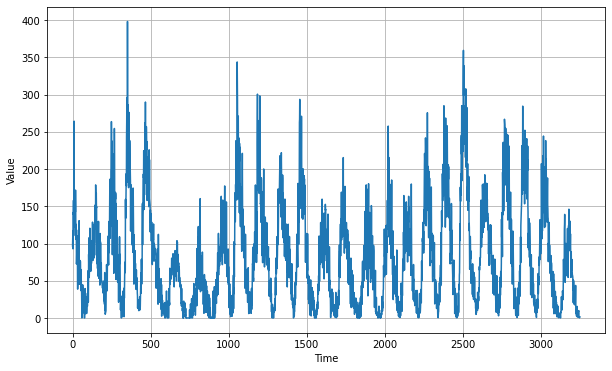

In [5]:
import csv
time_step = []
sunspots = []

# with open('/tmp/sunspots.csv') as csvfile:
with open('./dataset_sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

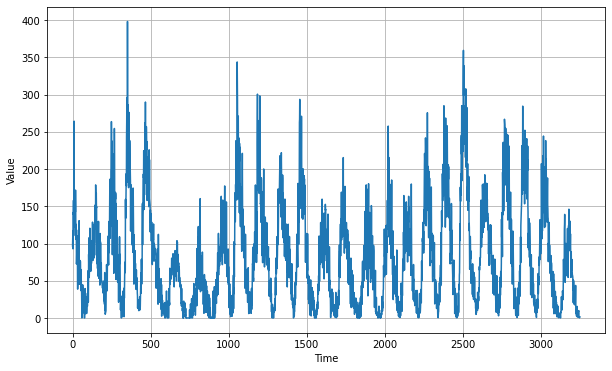

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 365ms/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 0s 41ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 1s 43ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 1s 45ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 1s 43ms/step - loss: 69.0173 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 1s 45ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 1s 45ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 1s 43ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 1s 44ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/12 [====

12/12 [==============================] - 1s 44ms/step - loss: 23.1938 - mae: 23.0411
Epoch 84/100
12/12 [==============================] - 1s 42ms/step - loss: 26.6604 - mae: 27.3232
Epoch 85/100
12/12 [==============================] - 1s 42ms/step - loss: 30.8251 - mae: 30.3129
Epoch 86/100
12/12 [==============================] - 1s 43ms/step - loss: 41.4997 - mae: 42.3622
Epoch 87/100
12/12 [==============================] - 1s 42ms/step - loss: 38.9137 - mae: 39.6605
Epoch 88/100
12/12 [==============================] - 1s 42ms/step - loss: 53.3168 - mae: 53.5612
Epoch 89/100
12/12 [==============================] - 1s 45ms/step - loss: 54.3788 - mae: 54.8210
Epoch 90/100
12/12 [==============================] - 1s 42ms/step - loss: 48.4295 - mae: 48.3955
Epoch 91/100
12/12 [==============================] - 1s 42ms/step - loss: 57.2623 - mae: 57.3669
Epoch 92/100
12/12 [==============================] - 1s 44ms/step - loss: 56.0606 - mae: 56.5785
Epoch 93/100
12/12 [=============

(1e-08, 0.0001, 0.0, 60.0)

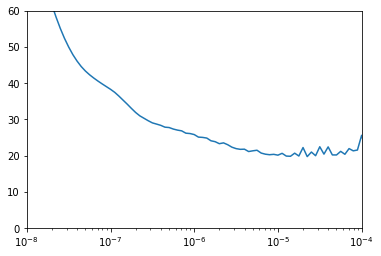

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 104ms/step - loss: 37.8963 - mae: 38.6055
Epoch 2/500
30/30 [==============================] - 1s 19ms/step - loss: 24.0687 - mae: 24.6058
Epoch 3/500
30/30 [==============================] - 1s 18ms/step - loss: 22.0090 - mae: 22.5064
Epoch 4/500
30/30 [==============================] - 1s 18ms/step - loss: 19.8751 - mae: 20.3535
Epoch 5/500
30/30 [==============================] - 1s 19ms/step - loss: 19.6934 - mae: 20.1911
Epoch 6/500
30/30 [==============================] - 1s 18ms/step - loss: 19.3771 - mae: 19.8733
Epoch 7/500
30/30 [==============================] - 1s 19ms/step - loss: 18.8637 - mae: 19.3536
Epoch 8/500
30/30 [==============================] - 1s 20ms/step - loss: 18.4532 - mae: 18.9691
Epoch 9/500
30/30 [==============================] - 1s 18ms/step - loss: 18.2364 - mae: 18.7002
Epoch 10/500
30/30 [==============================] - 1s 19ms/step - loss: 18.2149 - mae: 18.6860
Epoch 11/500
30/30 [========

30/30 [==============================] - 1s 20ms/step - loss: 16.3180 - mae: 16.7957
Epoch 85/500
30/30 [==============================] - 1s 20ms/step - loss: 16.3043 - mae: 16.7884
Epoch 86/500
30/30 [==============================] - 1s 21ms/step - loss: 16.4970 - mae: 16.9624
Epoch 87/500
30/30 [==============================] - 1s 19ms/step - loss: 17.1002 - mae: 17.5878
Epoch 88/500
30/30 [==============================] - 1s 19ms/step - loss: 16.7444 - mae: 17.1994
Epoch 89/500
30/30 [==============================] - 1s 20ms/step - loss: 16.3874 - mae: 16.8797
Epoch 90/500
30/30 [==============================] - 1s 21ms/step - loss: 16.3973 - mae: 16.8870
Epoch 91/500
30/30 [==============================] - 1s 20ms/step - loss: 16.4011 - mae: 16.8852
Epoch 92/500
30/30 [==============================] - 1s 20ms/step - loss: 16.4270 - mae: 16.8831
Epoch 93/500
30/30 [==============================] - 1s 19ms/step - loss: 16.4180 - mae: 16.9013
Epoch 94/500
30/30 [=============

30/30 [==============================] - 1s 20ms/step - loss: 15.9284 - mae: 16.4165
Epoch 167/500
30/30 [==============================] - 1s 20ms/step - loss: 16.0276 - mae: 16.5202
Epoch 168/500
30/30 [==============================] - 1s 19ms/step - loss: 15.8523 - mae: 16.3205
Epoch 169/500
30/30 [==============================] - 1s 19ms/step - loss: 15.8675 - mae: 16.3449
Epoch 170/500
30/30 [==============================] - 1s 20ms/step - loss: 15.8023 - mae: 16.2864
Epoch 171/500
30/30 [==============================] - 1s 19ms/step - loss: 15.9048 - mae: 16.3845
Epoch 172/500
30/30 [==============================] - 1s 19ms/step - loss: 15.7942 - mae: 16.2760
Epoch 173/500
30/30 [==============================] - 1s 20ms/step - loss: 15.7609 - mae: 16.2584
Epoch 174/500
30/30 [==============================] - 1s 19ms/step - loss: 15.9618 - mae: 16.4417
Epoch 175/500
30/30 [==============================] - 1s 20ms/step - loss: 15.8438 - mae: 16.3219
Epoch 176/500
30/30 [===

30/30 [==============================] - 1s 19ms/step - loss: 15.7646 - mae: 16.2446
Epoch 249/500
30/30 [==============================] - 1s 19ms/step - loss: 15.5065 - mae: 15.9668
Epoch 250/500
30/30 [==============================] - 1s 19ms/step - loss: 15.5542 - mae: 16.0371
Epoch 251/500
30/30 [==============================] - 1s 21ms/step - loss: 15.5053 - mae: 16.0174
Epoch 252/500
30/30 [==============================] - 1s 21ms/step - loss: 15.5454 - mae: 16.0493
Epoch 253/500
30/30 [==============================] - 1s 21ms/step - loss: 15.3838 - mae: 15.8682
Epoch 254/500
30/30 [==============================] - 1s 23ms/step - loss: 15.4628 - mae: 15.9445
Epoch 255/500
30/30 [==============================] - 1s 20ms/step - loss: 15.5264 - mae: 16.0466
Epoch 256/500
30/30 [==============================] - 1s 20ms/step - loss: 15.4366 - mae: 15.9209
Epoch 257/500
30/30 [==============================] - 1s 19ms/step - loss: 15.5086 - mae: 15.9681
Epoch 258/500
30/30 [===

30/30 [==============================] - 1s 20ms/step - loss: 15.1249 - mae: 15.6210
Epoch 331/500
30/30 [==============================] - 1s 20ms/step - loss: 15.0924 - mae: 15.5924
Epoch 332/500
30/30 [==============================] - 1s 23ms/step - loss: 15.0463 - mae: 15.5405
Epoch 333/500
30/30 [==============================] - 1s 19ms/step - loss: 15.0775 - mae: 15.5655
Epoch 334/500
30/30 [==============================] - 1s 19ms/step - loss: 15.1395 - mae: 15.6056
Epoch 335/500
30/30 [==============================] - 1s 23ms/step - loss: 15.1267 - mae: 15.6213
Epoch 336/500
30/30 [==============================] - 1s 21ms/step - loss: 15.0599 - mae: 15.5496
Epoch 337/500
30/30 [==============================] - 1s 22ms/step - loss: 14.9786 - mae: 15.4609
Epoch 338/500
30/30 [==============================] - 1s 22ms/step - loss: 14.9739 - mae: 15.4899
Epoch 339/500
30/30 [==============================] - 1s 19ms/step - loss: 14.9520 - mae: 15.4315
Epoch 340/500
30/30 [===

30/30 [==============================] - 1s 20ms/step - loss: 14.8296 - mae: 15.3166
Epoch 413/500
30/30 [==============================] - 1s 19ms/step - loss: 14.7226 - mae: 15.2049
Epoch 414/500
30/30 [==============================] - 1s 19ms/step - loss: 14.8281 - mae: 15.3124
Epoch 415/500
30/30 [==============================] - 1s 19ms/step - loss: 14.9058 - mae: 15.4197
Epoch 416/500
30/30 [==============================] - 1s 20ms/step - loss: 15.2384 - mae: 15.7112
Epoch 417/500
30/30 [==============================] - 1s 19ms/step - loss: 14.7646 - mae: 15.2730
Epoch 418/500
30/30 [==============================] - 1s 19ms/step - loss: 14.6274 - mae: 15.1017
Epoch 419/500
30/30 [==============================] - 1s 21ms/step - loss: 14.7335 - mae: 15.2480
Epoch 420/500
30/30 [==============================] - 1s 19ms/step - loss: 14.6279 - mae: 15.1227
Epoch 421/500
30/30 [==============================] - 1s 20ms/step - loss: 14.7062 - mae: 15.1874
Epoch 422/500
30/30 [===

30/30 [==============================] - 1s 22ms/step - loss: 14.3085 - mae: 14.7912
Epoch 494/500
30/30 [==============================] - 1s 23ms/step - loss: 14.4303 - mae: 14.9285
Epoch 495/500
30/30 [==============================] - 1s 18ms/step - loss: 14.3005 - mae: 14.7953
Epoch 496/500
30/30 [==============================] - 1s 21ms/step - loss: 14.3853 - mae: 14.8498
Epoch 497/500
30/30 [==============================] - 1s 22ms/step - loss: 14.2611 - mae: 14.7233
Epoch 498/500
30/30 [==============================] - 1s 19ms/step - loss: 14.3112 - mae: 14.7910
Epoch 499/500
30/30 [==============================] - 1s 18ms/step - loss: 14.5285 - mae: 15.0202
Epoch 500/500
30/30 [==============================] - 1s 18ms/step - loss: 14.5412 - mae: 15.0264


In [13]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

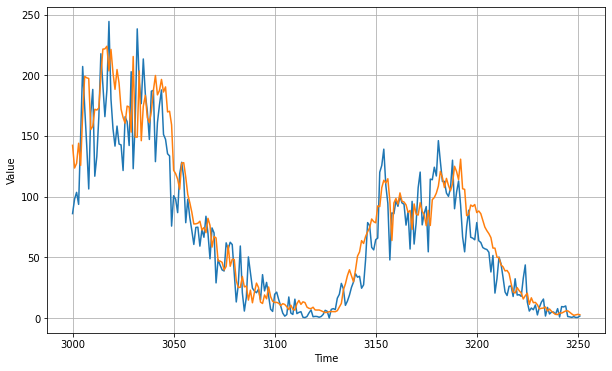

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.906618

<Figure size 432x288 with 0 Axes>

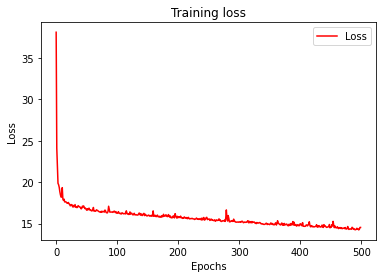

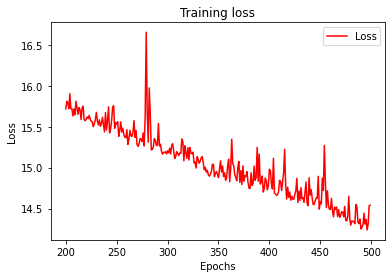

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[142.23502   123.544     127.43692   143.95251   125.73249   168.0737
 199.06107   197.88174   197.35443   155.28123   157.8982    171.95927
 171.29414   173.05295   199.23222   221.50937   221.71631   223.8894
 203.56602   221.27803   202.00517   188.37369   204.69966   193.561
 172.02429   165.22073   160.46138   174.58179   173.82663   153.09749
 215.43665   149.12231   148.97066   203.5556    146.04103   174.56215
 183.36697   164.9787    160.91524   170.31593   187.4655    199.80202
 183.83577   187.47975   196.54114   186.1597    190.38242   169.75803
 170.32245   159.08585   121.709946  118.92793   114.35742   106.06687
 127.613686  127.94524   116.04852   101.68407    95.07481    87.2016
  77.45598    77.57128    78.06205    79.73325    72.50353    74.498344
  70.27001    82.11937    76.32878    58.377743   67.183205   65.92962
  47.10285    46.874218   45.845066   39.535904   42.49511    59.65965
  42.61601    48.3525     48.183292   30.79583    25.121492   25.296963
  34.1708